# Poisson Sampling

This is a prototype of the Poisson sampling model for mapping counts from a spectral cube to the detector plane.

In [1]:
import pathlib
import tempfile

import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, LogStretch, AsymmetricPercentileInterval
import astropy.units as u
import ndcube
from astropy.wcs.utils import wcs_to_celestial_frame, pixel_to_pixel
import dask.array
import distributed

from overlappy.util import color_lat_lon_axes, strided_array
from mocksipipeline.util import stack_components, read_data_cube
from mocksipipeline.detector.filter import ThinFilmFilter
from mocksipipeline.detector.response import convolve_with_response, SpectrogramChannel, Channel

In [2]:
data_dir = pathlib.Path('data/')

In [3]:
client = distributed.Client()

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55570,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:55584,Total threads: 2
Dashboard: http://127.0.0.1:55586/status,Memory: 12.80 GiB
Nanny: tcp://127.0.0.1:55573,


## Poisson Sampling from overlappogram simulations

In [3]:
files = data_dir.glob('overlappogram-ar-photons-order=*.fits')

In [4]:
overlappogram = stack_components(sorted(files), wcs_index=2)

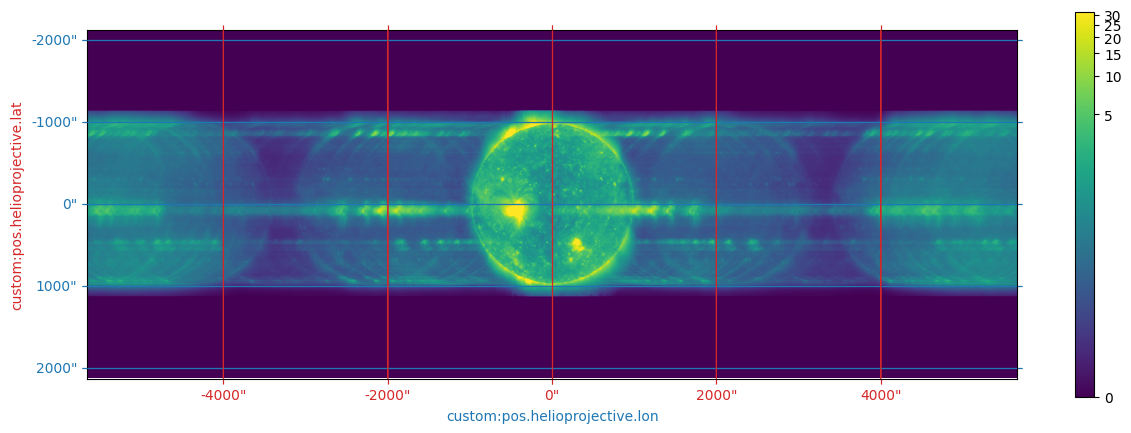

In [5]:
fig = plt.figure(figsize=(15,5))
vmin,vmax = AsymmetricPercentileInterval(1,99.9).get_limits(overlappogram[0].data*3600)
#vmin,vmax = None, None
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
ax = fig.add_subplot(projection=overlappogram[0].wcs)
overlappogram[0].plot(
    axes=ax,
    norm=norm,
    data_unit='photon / (pix h)',
    cmap='viridis',
)
color_lat_lon_axes(ax)
plt.colorbar()

Sample at $dt$ over some co-add interval $\Delta T$

In [6]:
dt = 1 * u.s
interval = 60 * u.minute
steps = int(np.ceil((interval / dt).decompose()))

In [7]:
probability_rate = overlappogram[0].data * overlappogram.unit * u.pix

In [10]:
lam = (probability_rate*dt).to_value('photon')
counts = np.random.poisson(lam=lam, size=(steps,)+lam.shape).sum(axis=0)*u.photon

In [11]:
poisson_counts = ndcube.NDCube(counts, wcs=overlappogram[0].wcs)

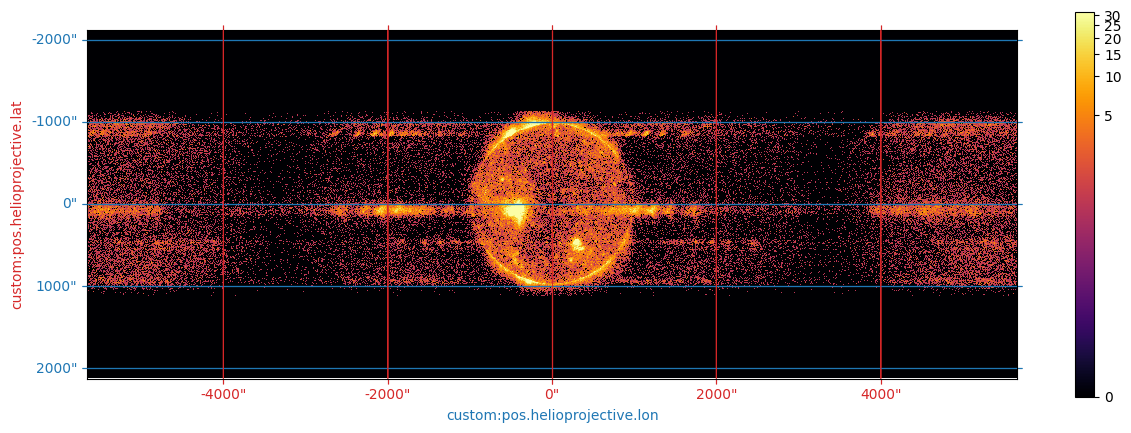

In [12]:
fig = plt.figure(figsize=(15,5))
vmin,vmax = AsymmetricPercentileInterval(1,99.9).get_limits(poisson_counts.data)
#vmin,vmax = None, None
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
ax = fig.add_subplot(projection=poisson_counts.wcs)
poisson_counts.plot(
    axes=ax,
    norm=norm,
    data_unit='photon',
    cmap='inferno',
    interpolation='none',
)
color_lat_lon_axes(ax)
plt.colorbar()

## Poisson Sampling from unprojected spectral cubes

In [5]:
spec_cube = read_data_cube(data_dir / 'moxsi-spectral-cube-ar.fits', hdu=1)

In [6]:
spec_cube

NDCube
------
Dimensions: [1073.  450.  450.] pix
Physical Types of Axes: [('em.wl',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: ph / (Angstrom cm2 s sr)
Data Type: float64

In [7]:
observer = wcs_to_celestial_frame(spec_cube.wcs).observer

In [6]:
observer

<HeliographicStonyhurst Coordinate (obstime=2020-11-09T18:00:06.640, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.006005, 3.43378555, 1.48126201e+11)>

In [7]:
chan0 = SpectrogramChannel(0)

In [24]:
instr_cube_0 = convolve_with_response(spec_cube, chan0, electrons=False)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [31]:
lam = (instr_cube_0.data * instr_cube_0.unit * u.pix * dt).to_value('photon')
lam = np.where(lam<0, 0, lam)

In [32]:
samples = np.random.poisson(lam=lam)

In [34]:
idx_nonzero = np.where(samples>0)

In [39]:
overlap_wcs_0 = chan0.get_wcs(observer)

  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]


In [43]:
coord_p2w, spec_coord_p2w = instr_cube_0.wcs.pixel_to_world(idx_nonzero[2], idx_nonzero[1], idx_nonzero[0])

In [44]:
coord_i2w, spec_coord_i2w = instr_cube_0.wcs.array_index_to_world(*idx_nonzero)

In [51]:
idx_nonzero_overlap = pixel_to_pixel(instr_cube_0.wcs, overlap_wcs_0, *idx_nonzero[::-1])

In [56]:
index_col, index_row, _ = idx_nonzero_overlap

In [58]:
n_rows = chan0.detector_shape[0]//2
n_cols = chan0.detector_shape[1]
range_row = [-.5, n_rows-.5]
range_col = [-.5, n_cols-.5]

In [59]:
hist, _, _ = np.histogram2d(index_row, index_col,
                            bins=(n_rows, n_cols),
                            range=(range_row, range_col),
                            weights=samples[idx_nonzero])

In [61]:
poisson_counts_0 = ndcube.NDCube(hist*u.photon, overlap_wcs_0[0])

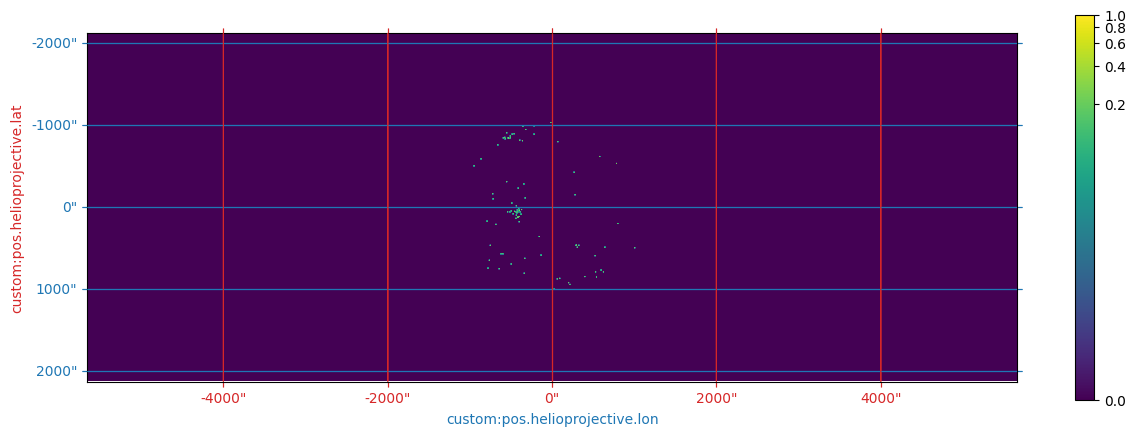

In [64]:
fig = plt.figure(figsize=(15,5))
vmin,vmax = 0,1
#vmin,vmax = None, None
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
ax = fig.add_subplot(projection=poisson_counts_0.wcs)
poisson_counts_0.plot(
    axes=ax,
    norm=norm,
    data_unit='photon',
    cmap='inferno',
)
color_lat_lon_axes(ax)
plt.colorbar()

In [7]:
def sample_spectral_cube(spec_cube, order, dt=1*u.s, interval=20*u.s):
    """
    Sample a Poisson distribution based on counts from spectral cube and map counts to detector pixels.
    """
    # Convert to instrument units
    observer = wcs_to_celestial_frame(spec_cube.wcs).observer
    chan = SpectrogramChannel(order)
    instr_cube = convolve_with_response(spec_cube, chan, electrons=False)
    # Sample distribution
    lam = (instr_cube.data * instr_cube.unit * u.pix * dt).to_value('photon')
    # NOTE: this should not be needed in general...
    lam = np.where(lam<0, 0, lam)
    lam = dask.array.from_array(lam, chunks='auto')
    num_iterations = int(np.ceil((interval / dt).decompose()))
    samples = dask.array.random.poisson(lam=lam, size=(num_iterations,)+lam.shape).sum(axis=0)
    samples = samples.compute()
    idx_nonzero = np.where(samples>0)
    # Map counts to detector coordinates
    overlap_wcs = chan.get_wcs(observer)
    idx_nonzero_overlap = pixel_to_pixel(instr_cube.wcs, overlap_wcs, *idx_nonzero[::-1])
    n_rows = chan.detector_shape[0]//2
    n_cols = chan.detector_shape[1]
    hist, _, _ = np.histogram2d(idx_nonzero_overlap[1], idx_nonzero_overlap[0],
                                bins=(n_rows, n_cols),
                                range=([-.5, n_rows-.5], [-.5, n_cols-.5]),
                                weights=samples[idx_nonzero])
    return ndcube.NDCube(strided_array(hist, chan.wavelength.shape[0],),
                         wcs=overlap_wcs,
                         unit='photon')

In [8]:
overlap_sample_0 = sample_spectral_cube(spec_cube, 0, dt=1*u.s, interval=1*u.minute)
overlap_sample_1 = sample_spectral_cube(spec_cube, 1, dt=1*u.s, interval=1*u.minute)
overlap_sample_3 = sample_spectral_cube(spec_cube, 3, dt=1*u.s, interval=1*u.minute)
overlap_sample_m1 = sample_spectral_cube(spec_cube, -1, dt=1*u.s, interval=1*u.minute)
overlap_sample_m3 = sample_spectral_cube(spec_cube, -3, dt=1*u.s, interval=1*u.minute)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 126.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 1.87 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
  'angstrom' -> 'A

In [9]:
overlap_sample_sum = ndcube.NDCube(
    overlap_sample_0.data + overlap_sample_1.data + overlap_sample_3.data + overlap_sample_m1.data + overlap_sample_m3.data,
    wcs=overlap_sample_0.wcs,
    unit=overlap_sample_0.unit,
)

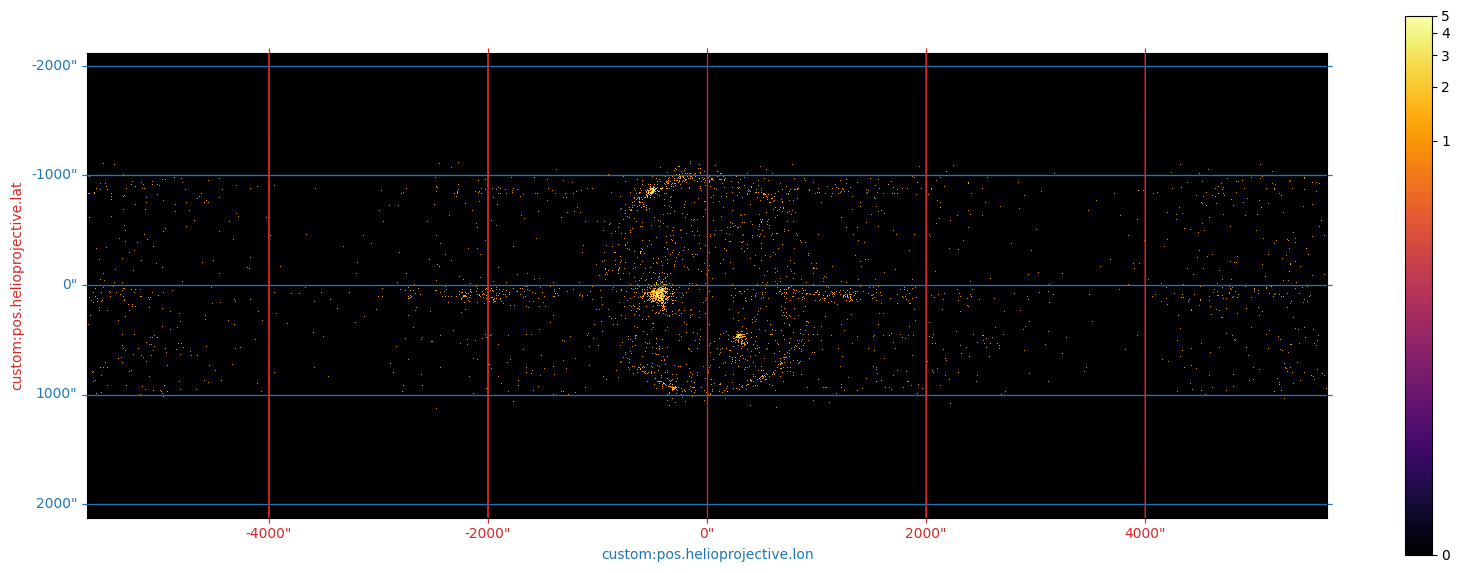

2023-05-24 02:18:01,951 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:55583', name: 1, status: running, memory: 0, processing: 0>
2023-05-24 02:18:01,953 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:55585', name: 2, status: running, memory: 0, processing: 0>
2023-05-24 02:18:01,953 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:55588', name: 4, status: running, memory: 0, processing: 0>
2023-05-24 02:18:04,084 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-05-24 02:18:04,084 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-05-24 02:18:04,087 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-05-24 15:29:15,172 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (thresho

In [15]:
fig = plt.figure(figsize=(20,7))
norm = ImageNormalize(vmin=0, vmax=5, stretch=LogStretch())
ax = fig.add_subplot(projection=overlap_sample_sum[0].wcs)
overlap_sample_sum[0].plot(
    axes=ax,
    norm=norm,
    data_unit='photon',
    cmap='inferno',
    interpolation='none',
)
color_lat_lon_axes(ax)
plt.colorbar()